# Testings and benchmarkings for univariate scan functions

We will be using the BXD data for testing purposes. In this notebook, we are testing the univariate scan functionalities, by performing the functions on the 108th BXD trait. 

## Preparation:

In [1]:
pwd()

"/Users/zifanyu/Documents/GitHub/BulkLMM.jl/test/notebooks"

In [2]:
cd("..")

In [3]:
include("BXDdata_for_test.jl"); ## Load BXD data used for testing:

In [4]:
include("../src/parallel_helpers.jl");

In [79]:
include("testHelper.jl");

In [5]:
kinship_Gc = CSV.read("run-gemma/output/kinship.cXX.txt", DataFrame, delim = '\t', header = false) |> Matrix;

In [6]:
using Test
using Plots

In [151]:
pheno_y = reshape(pheno[:, 108], :, 1);
(y0, X0, lambda0) = transform_rotation(pheno_y, geno, kinship_Gc); # by default will add an intercept to geno
X0_intercept = reshape(X0[:, 1], :, 1);
X0_covar = X0[:, 2:end];

## Test simple scans:

In [10]:
@time test_alt = scan(pheno_y, geno, kinship_Gc; reml = false, assumption = "alt", method = "qr");

  1.971169 seconds (5.79 M allocations: 2.600 GiB, 16.00% gc time)


In [20]:
lods_alt = test_alt[4];

In [58]:
findall(lods_alt .< 0) # confirm that uncorrected solution contains invalid LOD scores

241-element Vector{Int64}:
  229
  230
  231
  232
  233
  234
  235
  236
  237
  238
  239
  240
  241
    ⋮
 6112
 6113
 6114
 6115
 6116
 6117
 6118
 6119
 6123
 6124
 7227
 7228

perform correction by taking $(var(y_{108}), 0.1)$

In [22]:
var(pheno_y)

1.6944289276209026

In [23]:
prior = [var(pheno_y), 1/10]

2-element Vector{Float64}:
 1.6944289276209026
 0.1

In [18]:
@time test_alt_corrected = scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "qr");

  0.856707 seconds (2.63 M allocations: 1.180 GiB, 15.98% gc time)


In [24]:
lods_alt_corrected = test_alt_corrected[4];

In [25]:
findall(lods_alt_corrected .< 0)

Int64[]

In [29]:
hcat(lods_alt, lods_alt_corrected)

7321×2 Matrix{Float64}:
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.0219153  0.0199953
 0.021912   0.0199922
 0.0567256  0.0417663
 ⋮          
 0.248678   0.263758
 0.248678   0.263758
 0.248678   0.263758
 0.0686881  0.122407
 0.124881   0.136544
 0.124881   0.136544
 0.249213   0.255818
 0.273645   0.288192
 0.271594   0.285219
 0.285893   0.309153
 0.229505   0.219606
 0.229505   0.219606

In [27]:
@benchmark scan(pheno_y, geno, kinship_Gc; reml = false, assumption = "alt", method = "qr")

BenchmarkTools.Trial: 3 samples with 1 evaluation.
 Range (min … max):  1.745 s …   1.780 s  ┊ GC (min … max): 12.12% … 11.32%
 Time  (median):     1.751 s              ┊ GC (median):    12.08%
 Time  (mean ± σ):   1.759 s ± 18.314 ms  ┊ GC (mean ± σ):  11.86% ±  0.47%

  █        █                                              █  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.75 s         Histogram: frequency by time        1.78 s <

 Memory estimate: 2.60 GiB, allocs estimate: 5791909.

In [28]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "qr")

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  807.245 ms … 843.856 ms  ┊ GC (min … max): 12.93% … 14.11%
 Time  (median):     822.348 ms               ┊ GC (median):    12.70%
 Time  (mean ± σ):   826.035 ms ±  12.374 ms  ┊ GC (mean ± σ):  12.85% ±  0.89%

  █                   ██   █                 █    █           █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  807 ms           Histogram: frequency by time          844 ms <

 Memory estimate: 1.18 GiB, allocs estimate: 2625680.

In [35]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "alt", method = "cholesky")

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  534.107 ms … 588.627 ms  ┊ GC (min … max): 14.44% … 17.93%
 Time  (median):     555.800 ms               ┊ GC (median):    15.49%
 Time  (mean ± σ):   556.603 ms ±  13.846 ms  ┊ GC (mean ± σ):  15.51% ±  1.24%

  █            █      █ █████      █                          █  
  █▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▁█████▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  534 ms           Histogram: frequency by time          589 ms <

 Memory estimate: 935.14 MiB, allocs estimate: 2256464.

In [36]:
@benchmark scan(pheno_y, geno, kinship_Gc; prior_a = prior[1], prior_b = prior[2], reml = false, assumption = "null", method = "cholesky")

BenchmarkTools.Trial: 221 samples with 1 evaluation.
 Range (min … max):  19.601 ms … 30.492 ms  ┊ GC (min … max):  0.00% … 15.63%
 Time  (median):     20.799 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):   22.608 ms ±  2.669 ms  ┊ GC (mean ± σ):  10.01% ±  9.77%

   ▁█▂▁ ▂                                                      
  ▅████▇██▃▃▃▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▇█▆██▄▆▅▃▄▃▃▄▃▃▃▃▁▁▃▁▁▃▃▃▃▁▁▄ ▃
  19.6 ms         Histogram: frequency by time        28.6 ms <

 Memory estimate: 33.18 MiB, allocs estimate: 73514.

## Test scan with permutations:

In [94]:
include("../src/scan.jl");

In [66]:
?scan_perms

search: scan_perms scan_perms_distributed base_colorant_type



No documentation found.

`scan_perms` is a `Function`.

```
# 1 method for generic function "scan_perms":
[1] scan_perms(y::Matrix{Float64}, g::Matrix{Float64}, K::Matrix{Float64}; prior_a, prior_b, addIntercept, method, nperms, rndseed, reml, original) in Main at /Users/zifanyu/Documents/GitHub/BulkLMM.jl/src/scan.jl:214
```


In [73]:
try 
    scan_perms(pheno_y, geno, kinship_Gc; nperms = 0, original = false)
catch
    println("Exception caught: when permutations required is missing and the original is dropped.")
end

Exception caught: when permutations required is missing and the original is dropped.


When no permutation is required...

In [74]:
@time test_perms = scan_perms(pheno_y, geno, kinship_Gc; nperms = 0);

  0.049033 seconds (74.07 k allocations: 59.595 MiB, 34.70% gc time)


In [75]:
test_perms

1×7321 Matrix{Float64}:
 0.0219153  0.0219153  0.0219153  0.0219153  …  0.285893  0.229505  0.229505

In [95]:
test_null = scan(pheno_y, geno, kinship_Gc);

In [104]:
maxSqDiff(test_perms, reshape(test_null[3], 1, :))

1.2621774483536189e-27

In [118]:
@time test_perms_1000 = scan_perms(pheno_y, geno, kinship_Gc; method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);

  7.708020 seconds (104.26 k allocations: 17.624 GiB, 47.64% gc time)


Test serial scans on 1000 permuted traits...

In [127]:
BLAS.get_num_threads()

4

In [133]:
@btime scan_perms(pheno_y, geno, kinship_Gc; method = "qr", nperms = 1000, rndseed = 0, reml = false, original = true)

  9.563 s (104373 allocations: 17.62 GiB)


1001×7321 Matrix{Float64}:
 0.0219153   0.0219153   0.0219153   …  0.285893    0.229505    0.229505
 0.577071    0.577071    0.577071       0.26743     0.299685    0.299685
 0.416471    0.416471    0.416471       0.191429    0.192221    0.192221
 0.109243    0.109243    0.109243       0.0361814   0.0995112   0.0995112
 0.140566    0.140566    0.140566       0.0742643   0.0161596   0.0161596
 0.149453    0.149453    0.149453    …  0.0198113   0.0205044   0.0205044
 0.00739397  0.00739397  0.00739397     0.00137924  0.0134889   0.0134889
 0.00150617  0.00150617  0.00150617     0.0762705   0.199658    0.199658
 0.100859    0.100859    0.100859       0.0271475   0.0160348   0.0160348
 0.0018406   0.0018406   0.0018406      0.321976    0.393946    0.393946
 0.00113183  0.00113183  0.00113183  …  1.07409     1.29878     1.29878
 0.160275    0.160275    0.160275       0.37832     0.159057    0.159057
 0.157727    0.157727    0.157727       1.61675e-5  0.0136732   0.0136732
 ⋮                 

In [134]:
@btime begin
    prior_a = var(pheno_y);
    scan_perms(pheno_y, geno, kinship_Gc; prior_a = prior_a, prior_b = 0.1, method = "qr", nperms = 1000, rndseed = 0, reml = false, original = true);
end

  7.618 s (103872 allocations: 17.62 GiB)


1001×7321 Matrix{Float64}:
 0.0199558   0.0199558   0.0199558   0.0199558   …  0.221124     0.221124
 0.597741    0.597741    0.597741    0.597741       0.231237     0.231237
 0.565781    0.565781    0.565781    0.565781       0.166673     0.166673
 0.130609    0.130609    0.130609    0.130609       0.0984779    0.0984779
 0.235381    0.235381    0.235381    0.235381       0.0246234    0.0246234
 0.161319    0.161319    0.161319    0.161319    …  0.020107     0.020107
 0.00010056  0.00010056  0.00010056  0.00010056     0.030925     0.030925
 0.00635308  0.00635308  0.00635308  0.00635308     0.243614     0.243614
 0.0653776   0.0653776   0.0653776   0.0653776      0.0180202    0.0180202
 0.0060824   0.0060824   0.0060824   0.0060824      0.510765     0.510765
 0.0162535   0.0162535   0.0162535   0.0162535   …  1.20044      1.20044
 0.189371    0.189371    0.189371    0.189371       0.105339     0.105339
 0.0499736   0.0499736   0.0499736   0.0499736      0.0181551    0.0181551
 ⋮      

In [131]:
@btime begin
    prior_a = var(pheno_y);
    scan_perms(pheno_y, geno, kinship_Gc; prior_a = prior_a, prior_b = 0.1, method = "cholesky", nperms = 1000, rndseed = 0, reml = false, original = true);
end

  9.356 s (103830 allocations: 17.62 GiB)


1001×7321 Matrix{Float64}:
 0.0199558   0.0199558   0.0199558   0.0199558   …  0.221124     0.221124
 0.597741    0.597741    0.597741    0.597741       0.231237     0.231237
 0.565781    0.565781    0.565781    0.565781       0.166673     0.166673
 0.130609    0.130609    0.130609    0.130609       0.0984779    0.0984779
 0.235381    0.235381    0.235381    0.235381       0.0246234    0.0246234
 0.161319    0.161319    0.161319    0.161319    …  0.020107     0.020107
 0.00010056  0.00010056  0.00010056  0.00010056     0.030925     0.030925
 0.00635308  0.00635308  0.00635308  0.00635308     0.243614     0.243614
 0.0653776   0.0653776   0.0653776   0.0653776      0.0180202    0.0180202
 0.0060824   0.0060824   0.0060824   0.0060824      0.510765     0.510765
 0.0162535   0.0162535   0.0162535   0.0162535   …  1.20044      1.20044
 0.189371    0.189371    0.189371    0.189371       0.105339     0.105339
 0.0499736   0.0499736   0.0499736   0.0499736      0.0181551    0.0181551
 ⋮      

In [122]:
any(test_perms .< 0.0)

false

In [123]:
test_null[1]

3.455401663717786e-8

In [124]:
test_null[2]

0.999999984947842

In [156]:
c_pheno_y = copy(pheno_y);
c_geno = copy(geno);

In [157]:
colStandardize!(c_pheno_y);
colStandardize!(c_geno);

In [161]:
maxSqDiff(reshape(test_null[3], :, 1), reshape(scan(c_pheno_y, c_geno, kinship_Gc)[3], :, 1))

1.2621774483536189e-27

In [164]:
var(c_pheno_y)

1.0000000000000002

In [162]:
hcat(pheno_y, c_pheno_y)

79×2 Matrix{Float64}:
 6.874   0.643286
 5.771  -0.204066
 6.414   0.289903
 7.48    1.10883
 5.064  -0.747201
 5.71   -0.250928
 4.32   -1.31876
 6.845   0.621008
 8.018   1.52214
 6.772   0.564927
 7.372   1.02586
 4.71   -1.01915
 5.802  -0.180251
 ⋮      
 6.47    0.332923
 4.518  -1.16665
 7.542   1.15646
 4.665  -1.05372
 4.341  -1.30263
 6.955   0.705512
 4.338  -1.30493
 6.866   0.63714
 6.088   0.0394615
 6.248   0.162377
 6.727   0.530357
 7.182   0.879899

In [163]:
hcat(geno[:, 1], c_geno[:, 1])

79×2 Matrix{Float64}:
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 ⋮            
 5.18083e-11  -1.1141
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 5.18083e-11  -1.1141
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622
 1.0           0.88622

In [166]:
c_pheno = copy(pheno);

In [168]:
@time colStandardize!(c_pheno)

  0.061624 seconds (22 allocations: 834.797 KiB)


## Exploring the batching idea:

In [135]:
function get_hsqs_from_null(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    
    prior = zeros(2);
    prior[2] = 1/100;
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        prior[1] = var(y0_i);
        
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null (generic function with 1 method)

In [136]:
@time begin
    
    hsqs_from_null = get_hsqs_from_null(pheno, kinship_Gc; reml = false);
        
end

 10.326794 seconds (39.87 M allocations: 14.567 GiB, 20.68% gc time)


35556-element Vector{Float64}:
 5.252307989014744e-16
 3.0747546525840177e-15
 2.34890354044044e-15
 8.97201316153285e-16
 2.224913368023175e-15
 3.800605764727595e-15
 1.6536700148587646e-14
 3.6414645336939175e-14
 2.34890354044044e-15
 2.224913368023175e-15
 8.074343304670402e-15
 6.149509305168035e-15
 2.34890354044044e-15
 ⋮
 2.34890354044044e-15
 1.3750720834623256e-15
 0.1643203949220463
 0.07235333505058612
 8.97201316153285e-16
 2.466082349675042e-14
 4.06322116417833e-15
 2.73281150746183e-15
 6.400426481014958e-15
 0.06050234841340436
 6.149509305168035e-15
 1.375072083462324e-15

In [137]:
function get_hsqs_from_null_not_correct(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    prior = zeros(2);
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null_not_correct (generic function with 1 method)

In [138]:
@time begin
    
    hsqs_from_null_nc = get_hsqs_from_null_not_correct(pheno, kinship_Gc; reml = false);
        
end

  6.518447 seconds (25.06 M allocations: 9.147 GiB, 21.68% gc time)


35556-element Vector{Float64}:
 9.950115069895628e-15
 0.036528939421328205
 9.950115069895628e-15
 6.247563827463025e-15
 9.173598101430695e-15
 9.950115069895628e-15
 0.1305102674747561
 0.17410438338668452
 1.609962437506366e-14
 7.556752351802333e-15
 0.09142169755537538
 2.34890354044044e-15
 9.950115069895628e-15
 ⋮
 1.1034846708500515e-13
 2.6049739444959284e-14
 0.7218209389379234
 0.12763693428302544
 9.950115069895628e-15
 0.41810395059725675
 0.19611055191336954
 0.08632259430340487
 0.10927626211352637
 0.6094587891412765
 3.255168280819347e-13
 2.0235552928310703e-14

In [139]:
@benchmark get_hsqs_from_null(pheno, kinship_Gc; reml = false)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 10.551 s (21.12% GC) to evaluate,
 with a memory estimate of 14.57 GiB, over 39872075 allocations.

In [140]:
@benchmark get_hsqs_from_null_not_correct(pheno, kinship_Gc; reml = false)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.508 s (20.48% GC) to evaluate,
 with a memory estimate of 9.15 GiB, over 25059875 allocations.

In [141]:
maximum(hsqs_from_null)

0.9509585539087261

In [142]:
maximum(hsqs_from_null_nc)

0.999999984947842

In [169]:
function get_hsqs_from_null_std(Y::Array{Float64, 2}, K::Array{Float64, 2}; reml::Bool = false)

    (n, m) = size(Y);
    intercept = ones(n, 1);
    
    colStandardize!(Y);
    
    (Y0, intercept0, lambda0) = transform_rotation(Y, intercept, K; addIntercept = false);
    
    hsqs_from_null = Array{Float64, 1}(undef, m);
    prior = [1.0, 0.1];
    
    for i in 1:m
        
        y0_i = reshape(Y0[:, i], :, 1);
        out00 = fitlmm(y0_i, intercept0, lambda0, prior; reml = reml, method = "cholesky");
        hsqs_from_null[i] = out00.h2;
        
    end
    
    return hsqs_from_null;
    
end

get_hsqs_from_null_std (generic function with 1 method)

In [173]:
c_pheno = copy(pheno);
c_pheno[:, 108]

79-element Vector{Float64}:
 6.874
 5.771
 6.414
 7.48
 5.064
 5.71
 4.32
 6.845
 8.018
 6.772
 7.372
 4.71
 5.802
 ⋮
 6.47
 4.518
 7.542
 4.665
 4.341
 6.955
 4.338
 6.866
 6.088
 6.248
 6.727
 7.182

In [172]:
@benchmark get_hsqs_from_null_std(c_pheno, kinship_Gc; reml = false)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 6.515 s (20.66% GC) to evaluate,
 with a memory estimate of 9.05 GiB, over 24794559 allocations.

In [174]:
@time hsqs_from_null_std = get_hsqs_from_null_std(c_pheno, kinship_Gc; reml = false);

  6.417798 seconds (24.82 M allocations: 9.060 GiB, 20.58% gc time)


In [143]:
histogram(hsqs_from_null)

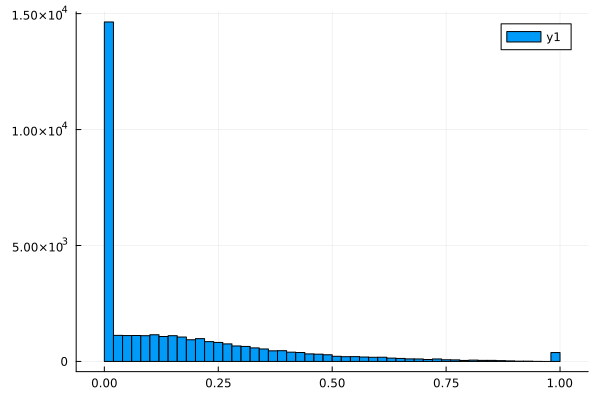

In [144]:
histogram(hsqs_from_null_nc)

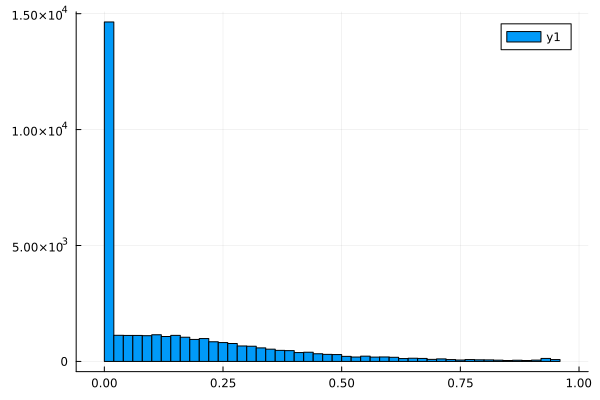

In [175]:
histogram(hsqs_from_null_std)